In [1]:
import tifffile
import numpy as np
from skimage.measure import regionprops_table
import pandas as pd
import glob
import os
import re
from anndata import AnnData
import scanpy as sc
import matplotlib.pyplot as plt

# Data

In [2]:
# # Directory containing your segmented mask TIFF files
# mask_dir = r'TNBC_shareCellData'
# # Output CSV file path
# output_csv = "cell_centroids.csv"

# records = []

# # Loop through each TIFF mask
# for mask_path in glob.glob(os.path.join(mask_dir, "*.tiff")):
#     # Load the mask (each cell labeled by a unique integer)
#     mask = tifffile.imread(mask_path)

#     print("Shape:", mask.shape)          # e.g. (1024, 1024)
#     print("Data type:", mask.dtype)      # e.g. uint16
#     labels = np.unique(mask)
#     print(f"Found {len(labels)-1} objects (ignoring background=0)")
#     print("Some label values:", labels[:10], "…", labels[-10:])
#     # Extract properties: label ID and centroids
#     props = regionprops_table(
#         mask,
#         properties=('label', 'centroid')
#     )
    
#     # Convert to DataFrame
#     df = pd.DataFrame(props)
#     # Keep track of source image
    
    
#     nums = re.search(r"\d+", os.path.basename(mask_path))
#     df['image'] = int(nums.group()) if nums else None
#     records.append(df)

# # Concatenate all image DataFrames
# all_cells = pd.concat(records, ignore_index=True)

# # Rename columns for clarity
# all_cells = all_cells.rename(
#     columns={
#         'label': 'CellID',
#         'centroid-0': 'CentroidY',
#         'centroid-1': 'CentroidX'
#     }
# )

# # Save to CSV
# all_cells.to_csv(output_csv, index=False)
# print(f"Saved {len(all_cells)} cell centroids to {output_csv}")

# all_cells

## Load cell expression data

In [3]:
data = pd.read_csv("TNBC_shareCellData/cellData.csv", sep=",")

# Filter bad patients
bad_Values = [42,43,44]
data = data[~data["SampleID"].isin(bad_Values)]

print(data.shape)
data.head()

(197678, 57)


,SampleID,cellLabelInImage,cellSize,C,Na,Si,P,Ca,Fe,dsDNA,...,MPO,Keratin6,HLA_Class_1,Ta,Au,tumorYN,tumorCluster,Group,immuneCluster,immuneGroup
0,1,2,146,0,-0.59061,0.875220,-2.57650,-0.806060,-0.2344,-1.308000,...,-0.13903,-0.41883,-0.53738,2.48110,2.32660,1,0,6,0,0
1,1,3,102,0,-0.49870,0.017464,-1.22490,-0.501520,-1.3412,0.522570,...,-0.13903,-0.52769,-0.62060,2.30430,2.18710,0,0,2,46,4
2,1,4,43,0,-1.48730,-0.630440,-1.91070,-1.228000,-1.3937,-1.782200,...,-0.13903,0.18774,-1.75050,1.39330,1.47820,1,0,6,0,0
3,1,5,211,0,-1.00530,-0.532270,-1.74300,-0.944850,-1.0996,-0.057906,...,-0.13903,-0.30976,-0.52445,1.88680,1.58620,1,0,6,0,0
4,1,6,177,0,0.15803,-0.710290,0.51737,-0.096251,-1.0526,0.355020,...,-0.13903,-0.52769,-0.99773,-0.51027,-0.49627,0,0,2,75,6


## Load patient labels

In [4]:
patient_labels = pd.read_csv("TNBC_shareCellData/patient_class.csv", header=None)

patient_labels.rename(columns={0:"SampleID", 1:"subtype"}, inplace=True)
subtype_map = {
    0: "Mixed",
    1: "Compartimentalized",
    2: "Cold"
}
# Map subtype integers to string labels
patient_labels["subtype"] = patient_labels["subtype"].map(subtype_map).astype('category')

print(patient_labels.shape)
patient_labels.head()

(41, 2)


,SampleID,subtype
0,1,Mixed
1,2,Mixed
2,3,Compartimentalized
3,4,Compartimentalized
4,5,Compartimentalized


## Load cell spatial coordinates

In [5]:
spatial_data = pd.read_csv('cell_centroids.csv', index_col=0)

print(spatial_data.shape)
spatial_data.head()

(249073, 3)


,CentroidY,CentroidX,image
CellID,,,
1,1030.426138,1076.394668,10
2,101.040609,33.959391,10
3,151.609665,34.289963,10
4,180.710069,38.015625,10
5,258.445378,32.294118,10


## Create Annotated data object

In [6]:
meta_cols = ['SampleID', 'cellLabelInImage', 'cellSize', 'tumorYN', 
             'tumorCluster', 'Group', 'immuneCluster', 'immuneGroup']
expr_cols = [c for c in data.columns if c not in meta_cols]

## Initial object
adata = AnnData(
    X = data[expr_cols].values,  # Use .values to ensure numpy array
    obs = data[meta_cols].reset_index(drop=True),  # Reset index to default integer
    var = pd.DataFrame(index=expr_cols)
)

## Create a unique id to merge expression data with spatial data
adata.obs["UniqueID"] = adata.obs['SampleID'].astype(str) + "_" + adata.obs['cellLabelInImage'].astype(str)
adata.obs = adata.obs.set_index('UniqueID')

spatial_data.reset_index(inplace=True)
spatial_data["UniqueID"] = spatial_data["image"].astype(str) + "_" + spatial_data["CellID"].astype(str)
spatial_data = spatial_data.set_index("UniqueID")

# Keep only the rows that match our expression data (in adata)
spatial_data = spatial_data.reindex(adata.obs_names)

adata.obsm["spatial"] = spatial_data[["CentroidX", "CentroidY"]].to_numpy()


## Map fine/coarse cell-type labels to interpretable strings
code2label_group = {
    1: "Unidentified",
    2: "Immune",
    3: "EndoThelial",
    4: "Mesenchymal-like",
    5: "Tumor",
    6: "Keratin-positive tumor"
}

code2label_immunegroup = {
    1: "Tregs",
    2: "CD4 T",
    3: "CD8 T",
    4: "CD3 T",
    5: "NK",
    6: "B",
    7: "Neutrophils",
    8: "Macrophages",
    9: "DC",
    10: "DC/Mono",
    11: "Mono/Neu",
    12: "Other immune"
}
adata.obs["Group"] = adata.obs["Group"].map(code2label_group)
adata.obs["immuneGroup"] = adata.obs["immuneGroup"].map(code2label_immunegroup)

adata.obs["fine_type"] = adata.obs["immuneGroup"].copy()
adata.obs.loc[adata.obs["fine_type"].isna(), "fine_type"] = adata.obs.loc[adata.obs["fine_type"].isna(), "Group"]

adata.obs = pd.merge(
    adata.obs,
    patient_labels,
    on="SampleID",
    how="left"
)
adata.obs

d:\miniforge3\envs\mlb\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,SampleID,cellLabelInImage,cellSize,tumorYN,tumorCluster,Group,immuneCluster,immuneGroup,fine_type,subtype
0,1,2,146,1,0,Keratin-positive tumor,0,NaN,Keratin-positive tumor,Mixed
1,1,3,102,0,0,Immune,46,CD3 T,CD3 T,Mixed
2,1,4,43,1,0,Keratin-positive tumor,0,NaN,Keratin-positive tumor,Mixed
3,1,5,211,1,0,Keratin-positive tumor,0,NaN,Keratin-positive tumor,Mixed
4,1,6,177,0,0,Immune,75,B,B,Mixed
...,...,...,...,...,...,...,...,...,...,...
197673,41,5093,90,1,0,Keratin-positive tumor,0,NaN,Keratin-positive tumor,Compartimentalized
197674,41,5094,132,1,21,Tumor,0,NaN,Tumor,Compartimentalized
197675,41,5095,123,0,0,Immune,31,Macrophages,Macrophages,Compartimentalized
197676,41,5096,99,0,0,Immune,56,Other immune,Other immune,Compartimentalized


In [7]:
adata.X

array([[ 0.       , -0.59061  ,  0.87522  , ..., -0.53738  ,  2.4811   ,
         2.3266   ],
       [ 0.       , -0.4987   ,  0.017464 , ..., -0.6206   ,  2.3043   ,
         2.1871   ],
       [ 0.       , -1.4873   , -0.63044  , ..., -1.7505   ,  1.3933   ,
         1.4782   ],
       ...,
       [ 0.       , -0.39525  , -0.1462   , ..., -0.0049209,  1.9665   ,
         1.8456   ],
       [ 0.       , -0.75282  ,  0.49475  , ...,  0.024687 ,  1.3716   ,
         1.6196   ],
       [ 0.       , -0.98901  ,  0.54594  , ...,  0.41896  ,  0.82349  ,
         0.77602  ]])

# Analysis

In [8]:
patient_labels['subtype'].value_counts()

subtype
Mixed                 20
Compartimentalized    15
Cold                   6
Name: count, dtype: int64

In [9]:
adata = adata[adata.obs["subtype"] == "Mixed"].copy()
adata.obs

d:\miniforge3\envs\mlb\lib\site-packages\anndata\_core\anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


,SampleID,cellLabelInImage,cellSize,tumorYN,tumorCluster,Group,immuneCluster,immuneGroup,fine_type,subtype
0,1,2,146,1,0,Keratin-positive tumor,0,NaN,Keratin-positive tumor,Mixed
1,1,3,102,0,0,Immune,46,CD3 T,CD3 T,Mixed
2,1,4,43,1,0,Keratin-positive tumor,0,NaN,Keratin-positive tumor,Mixed
3,1,5,211,1,0,Keratin-positive tumor,0,NaN,Keratin-positive tumor,Mixed
4,1,6,177,0,0,Immune,75,B,B,Mixed
...,...,...,...,...,...,...,...,...,...,...
188856,39,4656,178,1,0,Keratin-positive tumor,0,NaN,Keratin-positive tumor,Mixed
188857,39,4657,100,1,29,EndoThelial,0,NaN,EndoThelial,Mixed
188858,39,4658,65,0,0,Immune,100,Macrophages,Macrophages,Mixed
188859,39,4659,120,0,0,Immune,100,Macrophages,Macrophages,Mixed


## UMAP

In [10]:
# UMAP visualization of expression data
sc.pp.scale(adata, zero_center=True, max_value=None)

# Compute neighbors and run UMAP
sc.pp.neighbors(adata, n_neighbors=15, use_rep='X', metric='euclidean')
sc.tl.umap(adata, min_dist=0.5, spread=1.0)



d:\miniforge3\envs\mlb\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


d:\miniforge3\envs\mlb\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


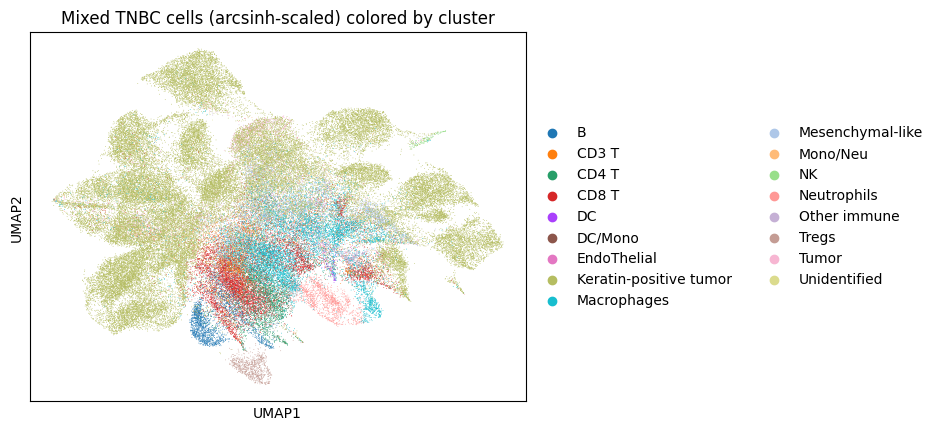

In [11]:
# Plot UMAP coloring by Leiden or another label
sc.pl.umap(adata, color='fine_type', title='Mixed TNBC cells (arcsinh-scaled) colored by cluster')
plt.show()

## Leiden clustering

d:\miniforge3\envs\mlb\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


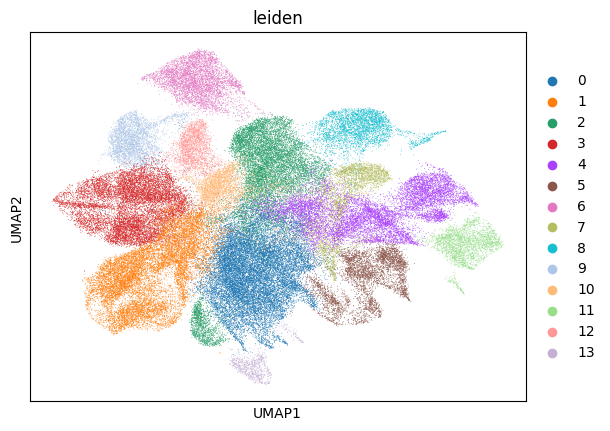

In [12]:
# Perform Leiden clustering on adata.X
# Assumes neighbors and PCA have already been computed (required for Leiden)
sc.tl.leiden(adata, resolution=0.25, key_added='leiden')

# Show cluster counts
# print(adata.obs['leiden'].value_counts())

# Optionally, visualize clusters on UMAP
sc.pl.umap(adata, color='leiden')
plt.show()

In [13]:
for pid, ad in adata.obs.groupby('SampleID').groups.items():
    sc.pl.spatial(
        adata[ad],
        color='leiden',
        title=f'Patient {pid}: mixed-subtype clusters',
        img_key='tissue_image'
    )


ValueError: When .uns['spatial'][library_id] does not exist, spot_size must be provided directly.

In [ ]:
# # Plot spatial results of Leiden clustering
# import matplotlib.pyplot as plt

# # Ensure spatial coordinates are available
# if 'spatial' in adata.obsm:
#     plt.figure(figsize=(8, 8))
#     scatter = plt.scatter(
#         adata.obsm['spatial'][:, 0],
#         adata.obsm['spatial'][:, 1],
#         c=adata.obs['fine_type'].astype(int),
#         cmap='tab20',
#         s=10,
#         alpha=0.7
#     )
#     plt.xlabel('CentroidX')
#     plt.ylabel('CentroidY')
#     plt.title('Spatial Plot of Leiden Clusters')
#     plt.gca().set_aspect('equal')
#     plt.colorbar(scatter, label='Leiden Cluster')
#     plt.show()
# else:
#     print('Spatial coordinates not found in adata.obsm["spatial"]')

ValueError: Cannot cast object dtype to int32

<Figure size 800x800 with 0 Axes>

C:\Users\Konstantinos\AppData\Local\Temp\ipykernel_19644\308171932.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = cm.get_cmap('tab20', len(unique_labels))


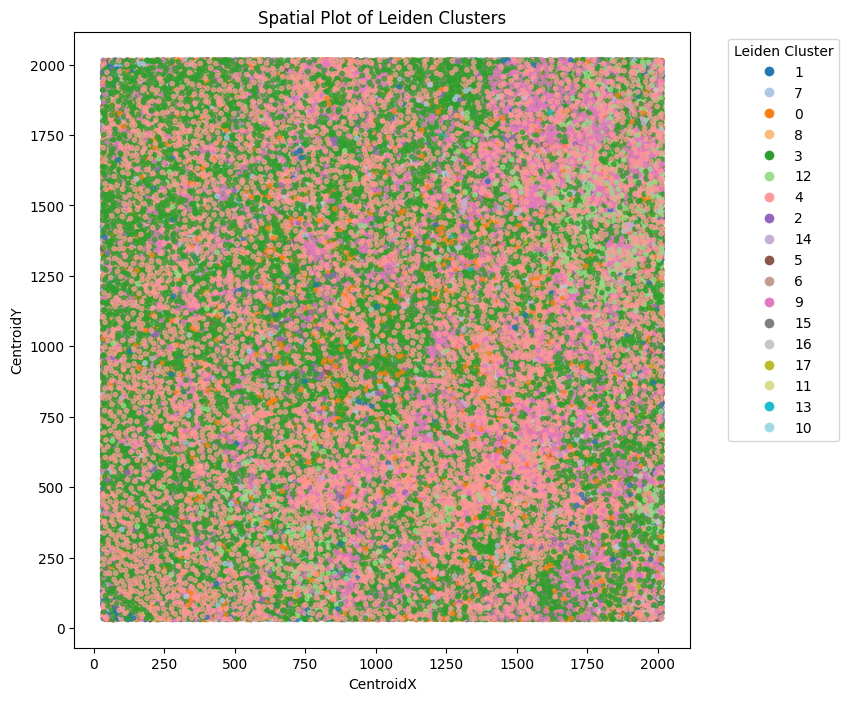

In [ ]:
# # Plot spatial results of Leiden clustering (fixed)
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import numpy as np

# if 'spatial' in adata.obsm:
#     plt.figure(figsize=(8, 8))
#     leiden_labels = adata.obs['leiden'].astype(str)
#     unique_labels = leiden_labels.unique()
#     colors = cm.get_cmap('tab20', len(unique_labels))
#     color_dict = {label: colors(i) for i, label in enumerate(unique_labels)}
#     cluster_colors = leiden_labels.map(color_dict)
#     scatter = plt.scatter(
#         adata.obsm['spatial'][:, 0],
#         adata.obsm['spatial'][:, 1],
#         c=cluster_colors,
#         s=10,
#         alpha=0.7
#     )
#     plt.xlabel('CentroidX')
#     plt.ylabel('CentroidY')
#     plt.title('Spatial Plot of Leiden Clusters')
#     plt.gca().set_aspect('equal')
#     # Create a legend
#     handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
#                           markerfacecolor=color_dict[label], markersize=8)
#                for label in unique_labels]
#     plt.legend(handles=handles, title='Leiden Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.show()
# else:
#     print('Spatial coordinates not found in adata.obsm["spatial"]')